In [1]:
!pip install kornia

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


In [2]:
#!pip install timm einops

In [3]:
from transformers import AutoModelForImageSegmentation
birefnet = AutoModelForImageSegmentation.from_pretrained('ZhengPeng7/BiRefNet', trust_remote_code=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/405 [00:00<?, ?B/s]

BiRefNet_config.py:   0%|          | 0.00/298 [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ZhengPeng7/BiRefNet:
- BiRefNet_config.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


birefnet.py:   0%|          | 0.00/92.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ZhengPeng7/BiRefNet:
- birefnet.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.11/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


model.safetensors:   0%|          | 0.00/885M [00:00<?, ?B/s]

In [4]:
!pip install pytorchtools

In [5]:
#!pip install wandb

In [6]:
#!pip install torch-xla -f https://storage.googleapis.com/libtpu-releases/index.html

In [7]:
#!pip uninstall -y torch torch_xla torchvision

In [8]:
#!pip install torch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0 -f https://download.pytorch.org/whl/cu118.html
#!pip install torch-xla[tpu] -f https://storage.googleapis.com/libtpu-releases/index.html

In [9]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from google.colab import drive
import torch.nn.functional as F
import matplotlib.pyplot as plt
import wandb
from torch.optim.lr_scheduler import ReduceLROnPlateau
#import torch_xla
#import torch_xla.core.xla_model as xm
# from models.birefnet import BiRefNet

In [10]:
# один раз перед работой, если есть новые маски

'''drive.mount('/content/drive')
masks_dir = '/content/drive/MyDrive/Курсовая/masks'
threshold = 20

for filename in os.listdir(masks_dir):
    if filename.endswith('.png'):
        file_path = os.path.join(masks_dir, filename)
        img = Image.open(file_path)
        gray = img.convert('L')  # градации серого
        arr = np.array(gray)
        bin_arr = np.where(arr > threshold, 255, 0).astype(np.uint8)  # если больше 20, то 255, иначе 0
        bin_mask = Image.fromarray(bin_arr)
        bin_mask.save(file_path)
        print(f'Processed {filename}')'''

"drive.mount('/content/drive')\nmasks_dir = '/content/drive/MyDrive/Курсовая/masks'\nthreshold = 20\n\nfor filename in os.listdir(masks_dir):\n    if filename.endswith('.png'):\n        file_path = os.path.join(masks_dir, filename)\n        img = Image.open(file_path)\n        gray = img.convert('L')  # градации серого\n        arr = np.array(gray)\n        bin_arr = np.where(arr > threshold, 255, 0).astype(np.uint8)  # если больше 20, то 255, иначе 0\n        bin_mask = Image.fromarray(bin_arr)\n        bin_mask.save(file_path)\n        print(f'Processed {filename}')"

In [11]:
wandb.init(project='segmentation_birefnet_8testpic', config={'epochs': 100, 'batch_size': 16,'learning_rate': 1e-4})
config = wandb.config

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kalinicheva2007 (pdftotex) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [12]:
birefnet.train()

BiRefNet(
  (bb): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=192, out_features=576, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=192, out_features=192, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=192, out_features=768, bias=T

In [13]:
class CustomDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.image_files = sorted(f for f in os.listdir(image_dir) if f.endswith('.jpg'))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        mask_name = os.path.splitext(img_name)[0] + '.png'  # имя маски совпадает с именем изображения, разница в расширении
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, mask_name)
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        #print("Mask range:", mask.min().item(), mask.max().item())

        return image, mask, img_name

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

drive.mount('/content/drive')
mask_dir = '/content/drive/MyDrive/Курсовая/masks'
image_dir = '/content/drive/MyDrive/Курсовая/images'
# image_dir = '/content/images'
# mask_dir = '/content/masks'
dataset = CustomDataset(image_dir=image_dir, mask_dir=mask_dir, image_transform=transform, mask_transform=mask_transform)
# dataloader = DataLoader(dataset, batch_size=2, shuffle=True)  # batch 2 для теста

train_size = int(0.7 * len(dataset))  # 70% - обучение
val_size = int(0.15 * len(dataset))   # 15% - валидация
test_size = len(dataset) - train_size - val_size  # остальное - тест

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_set, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=config.batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=config.batch_size, shuffle=False)
'''train_loader = DataLoader(train_set, batch_size=config.batch_size, shuffle=True, num_workers=16, drop_last=True)
val_loader = DataLoader(val_set, batch_size=config.batch_size, shuffle=False, num_workers=8)
test_loader = DataLoader(test_set, batch_size=config.batch_size, shuffle=False, num_workers=8)'''

Mounted at /content/drive


'train_loader = DataLoader(train_set, batch_size=config.batch_size, shuffle=True, num_workers=16, drop_last=True)\nval_loader = DataLoader(val_set, batch_size=config.batch_size, shuffle=False, num_workers=8)\ntest_loader = DataLoader(test_set, batch_size=config.batch_size, shuffle=False, num_workers=8)'

In [14]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, verbose=False, save_path='/content/drive/MyDrive/Курсовая/best_model.pth'):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.save_path = save_path
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, model, val_loss):  # если модель улучшилась, то сохраняем, если нет, то увеличиваем счётчик
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

        return self.early_stop

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.save_path)
        if self.verbose:
            print(f'Сохранены новые лучшие веса модели в: {self.save_path}')

    def load_best_model(self, model):
        model.load_state_dict(torch.load(self.save_path))
        if self.verbose:
            print(f'Загружены лучшие веса модели из: {self.save_path}')


In [15]:
# для бинарной сегментации
# targets 0 или 1
# smooth чтобы на 0 не делить
def dice_loss(inputs, targets, smooth=1e-6):
    inputs = torch.sigmoid(inputs)  # преобразование логитов к [0, 1]
    inputs = inputs.view(-1)  # векторизуем
    targets = targets.view(-1)

    intersection = (inputs * targets).sum()
    dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
    return 1 - dice

# только dice loss не справлялся на нормальном уровне. по числам было ок, по картинкам ужас
class BCEDiceLoss(nn.Module):
    def __init__(self, weight=None, smooth=1e-6):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss(weight=weight)
        self.smooth = smooth

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        d_loss = dice_loss(inputs, targets, smooth=self.smooth)
        return bce_loss + d_loss

In [16]:
# criterion = nn.BCEWithLogitsLoss()
criterion = BCEDiceLoss()
optimizer = optim.Adam(birefnet.parameters(), lr=0.001)

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
birefnet.to(device)

#device = xm.xla_device()
#birefnet = birefnet.to(device)

BiRefNet(
  (bb): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=192, out_features=576, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=192, out_features=192, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=192, out_features=768, bias=T

In [18]:
def extract_first_tensor(x):
    if isinstance(x, torch.Tensor):
        return x
    elif isinstance(x, (list, tuple)):
        for item in x:
            res = extract_first_tensor(item)
            if res is not None:
                return res
    return None

In [19]:
def pixel_accuracy(pred, target):
    correct = (pred == target).float().sum()
    total = torch.numel(pred)
    return correct / total

def iou_score(pred, target):
    pred = pred.long()
    target = target.long()
    intersection = (pred & target).float().sum(dim=(1,2,3))  # sum по C, H и W
    union = (pred | target).float().sum(dim=(1,2,3))
    iou = (intersection / (union + 1e-7)).mean()
    return iou

def dice_score(pred, target):
    pred = pred.float()
    target = target.float()
    intersection = (pred * target).sum(dim=(1,2,3))
    dice = (2.0 * intersection) / (pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3)) + 1e-7)
    return dice.mean()

In [20]:
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)  # снижаем lr если val_loss не улучшается

In [21]:
# num_epochs = 20
wandb.watch(birefnet, log='all')
num_epochs = wandb.config.epochs
early_stopping = EarlyStopping(patience=10, verbose=True, save_path='best_model.pth')

for epoch in range(num_epochs):
    birefnet.train()
    running_loss = 0.0
    running_acc = 0.0
    running_iou = 0.0
    running_dice = 0.0
    num_batches = 0

    for images, masks, filenames in train_loader:
        optimizer.zero_grad()
        if isinstance(masks, list):
            masks = torch.stack(masks, dim=0)
        #images = xm.send_cpu_data_to_device(images, device)
        #masks = xm.send_cpu_data_to_device(masks, device)

        masks = masks.to(device)
        images = images.to(device)
        #outputs = birefnet(images)
        try:
            outputs = birefnet(images)
        except Exception as e:
            print(f"Ошибка на изображении: {filenames}")
            print(f"Ошибка: {e}")
            break

        outputs_tensor = extract_first_tensor(outputs)
        if outputs_tensor is None:
            raise ValueError('Не удалось извлечь тензор из outputs')
        # print('Outputs shape:', outputs_tensor.shape)
        outputs_tensor = F.interpolate(outputs_tensor, size=masks.shape[-2:], mode='bilinear', align_corners=False)
        loss = criterion(outputs_tensor, masks)
        # loss = dice_loss(outputs_tensor, masks)
        loss.backward()
        optimizer.step()
        #xm.optimizer_step(optimizer, barrier=True)

        running_loss += loss.item()

        preds = torch.sigmoid(outputs_tensor)
        preds = (preds > 0.5).float()

        acc = pixel_accuracy(preds, masks)
        running_acc += acc.item()
        iou_val = iou_score(preds, masks)
        running_iou += iou_val.item()
        dice_val = dice_score(preds, masks)
        running_dice += dice_val.item()
        num_batches += 1

    birefnet.eval()
    val_loss = 0.0
    val_acc = 0.0
    val_iou = 0.0
    val_dice = 0.0
    num_val_batches = 0

    with torch.no_grad():
        for images, masks, filenames in val_loader:
            if isinstance(masks, list):
                masks = torch.stack(masks, dim=0)
            masks = masks.to(device)
            images = images.to(device)

            #images = xm.send_cpu_data_to_device(images, device)
            #masks = xm.send_cpu_data_to_device(masks, device)
            outputs = birefnet(images)
            outputs_tensor = extract_first_tensor(outputs)
            if outputs_tensor is None:
                raise ValueError('Не удалось извлечь тензор из outputs')
            outputs_tensor = F.interpolate(outputs_tensor, size=masks.shape[-2:], mode='bilinear', align_corners=False)

            loss = criterion(outputs_tensor, masks)
            val_loss += loss.item()
            preds = torch.sigmoid(outputs_tensor) > 0.5
            val_acc += pixel_accuracy(preds, masks).item()
            val_iou += iou_score(preds, masks).item()
            val_dice += dice_score(preds, masks).item()
            num_val_batches += 1

    val_loss /= num_val_batches
    val_acc /= num_val_batches
    val_iou /= num_val_batches
    val_dice /= num_val_batches

    # print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(dataloader):.4f}')
    epoch_loss = running_loss / num_batches
    epoch_acc = running_acc / num_batches
    # print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Pixel Accuracy: {epoch_acc:.4f}')
    epoch_iou  = running_iou  / num_batches
    epoch_dice = running_dice / num_batches

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {epoch_loss:.4f}, '
          f'Val Loss: {val_loss:.4f}, '
          f'Pixel Acc: {epoch_acc:.4f}, '
          f'IoU: {epoch_iou:.4f}, '
          f'Dice: {epoch_dice:.4f}')

    wandb.log({'epoch': epoch + 1,
               'train_loss': epoch_loss,
               'val_loss': val_loss,
               'pixel_accuracy': epoch_acc,
               'iou': epoch_iou,
               'dice': epoch_dice})

    scheduler.step(epoch_loss)
    if early_stopping(birefnet, val_loss):
        print('Остановка обучения. Сохранение лучших весов.')
        break

Epoch [1/100], Train Loss: 1.1995, Val Loss: 3.6658, Pixel Acc: 0.7730, IoU: 0.4329, Dice: 0.5775
Сохранены новые лучшие веса модели в: best_model.pth
Epoch [2/100], Train Loss: 0.9775, Val Loss: 2.6174, Pixel Acc: 0.8231, IoU: 0.5086, Dice: 0.6517
Сохранены новые лучшие веса модели в: best_model.pth
Epoch [3/100], Train Loss: 0.8245, Val Loss: 2.2968, Pixel Acc: 0.8368, IoU: 0.5459, Dice: 0.6819
Сохранены новые лучшие веса модели в: best_model.pth
Epoch [4/100], Train Loss: 0.7287, Val Loss: 4.4592, Pixel Acc: 0.8461, IoU: 0.5765, Dice: 0.7112
EarlyStopping counter: 1/10
Epoch [5/100], Train Loss: 0.6744, Val Loss: 2.4214, Pixel Acc: 0.8536, IoU: 0.5887, Dice: 0.7195
EarlyStopping counter: 2/10
Epoch [6/100], Train Loss: 0.6575, Val Loss: 5.3088, Pixel Acc: 0.8560, IoU: 0.5880, Dice: 0.7177
EarlyStopping counter: 3/10
Epoch [7/100], Train Loss: 0.6369, Val Loss: 2.2514, Pixel Acc: 0.8602, IoU: 0.6099, Dice: 0.7377
Сохранены новые лучшие веса модели в: best_model.pth
Epoch [8/100], Tra

In [22]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 7
microcode	: 0xffffffff
cpu MHz		: 2200.222
cache size	: 39424 KB
physical id	: 0
siblings	: 12
core id		: 0
cpu cores	: 6
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp ibrs_enhanced fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves arat avx512_vnni md_clear arch_capabilities
bugs		: spectre_v1 spectre_v2 spec_store_bypass swapgs ta

In [23]:
!uname -a

Linux f20f5cb1bb23 6.1.85+ #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024 x86_64 x86_64 x86_64 GNU/Linux


In [24]:
import torchvision
print('torch version:', torch.__version__)
print('torchvision version:', torchvision.__version__)

torch version: 2.5.1+cu124
torchvision version: 0.20.1+cu124


In [25]:
birefnet.eval()

test_loss = 0.0
test_acc = 0.0
test_iou = 0.0
test_dice = 0.0
num_batches = 0

with torch.no_grad():
    for images, masks, filenames in test_loader:
        try:
            if isinstance(masks, list):
                masks = torch.stack(masks, dim=0)
            masks = masks.to(device)
            images = images.to(device)

            outputs = birefnet(images)
            outputs_tensor = extract_first_tensor(outputs)
            if outputs_tensor is None:
                raise ValueError('Не удалось извлечь тензор из outputs')
            outputs_tensor = F.interpolate(outputs_tensor, size=masks.shape[-2:], mode='bilinear', align_corners=False)

            loss = criterion(outputs_tensor, masks)
            test_loss += loss.item()
            preds = torch.sigmoid(outputs_tensor) > 0.5

            test_acc += pixel_accuracy(preds, masks).item()
            test_iou += iou_score(preds, masks).item()
            test_dice += dice_score(preds, masks).item()
            num_batches += 1
        except FileNotFoundError as e:
            print(f'Ошибка: {e} — пропускаем {filenames}')
            continue
        except Exception as e:
            print(f'Ошибка с {filenames}: {e}')
            continue

test_loss /= num_batches
test_acc /= num_batches
test_iou /= num_batches
test_dice /= num_batches

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Pixel Accuracy: {test_acc:.4f}')
print(f'Test IoU: {test_iou:.4f}')
print(f'Test Dice: {test_dice:.4f}')

Test Loss: 6.3485
Test Pixel Accuracy: 0.8109
Test IoU: 0.5149
Test Dice: 0.6703


In [26]:
birefnet.load_state_dict(torch.load("/content/best_model.pth", map_location=device))
birefnet.eval()

test_loss = 0.0
test_acc = 0.0
test_iou = 0.0
test_dice = 0.0
num_batches = 0

with torch.no_grad():
    for images, masks, filenames in test_loader:
        try:
            if isinstance(masks, list):
                masks = torch.stack(masks, dim=0)
            masks = masks.to(device)
            images = images.to(device)

            outputs = birefnet(images)
            outputs_tensor = extract_first_tensor(outputs)
            if outputs_tensor is None:
                raise ValueError('Не удалось извлечь тензор из outputs')
            outputs_tensor = F.interpolate(outputs_tensor, size=masks.shape[-2:], mode='bilinear', align_corners=False)

            loss = criterion(outputs_tensor, masks)
            test_loss += loss.item()
            preds = torch.sigmoid(outputs_tensor) > 0.5

            test_acc += pixel_accuracy(preds, masks).item()
            test_iou += iou_score(preds, masks).item()
            test_dice += dice_score(preds, masks).item()
            num_batches += 1
        except FileNotFoundError as e:
            print(f'Ошибка: {e} — пропускаем {filenames}')
            continue
        except Exception as e:
            print(f'Ошибка с {filenames}: {e}')
            continue

test_loss /= num_batches
test_acc /= num_batches
test_iou /= num_batches
test_dice /= num_batches

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Pixel Accuracy: {test_acc:.4f}')
print(f'Test IoU: {test_iou:.4f}')
print(f'Test Dice: {test_dice:.4f}')

<ipython-input-26-75ee373760e6>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  birefnet.load_state_dict(torch.load("/content/best_model.pth", map_location=device))


Test Loss: 1.6297
Test Pixel Accuracy: 0.8368
Test IoU: 0.4738
Test Dice: 0.5972


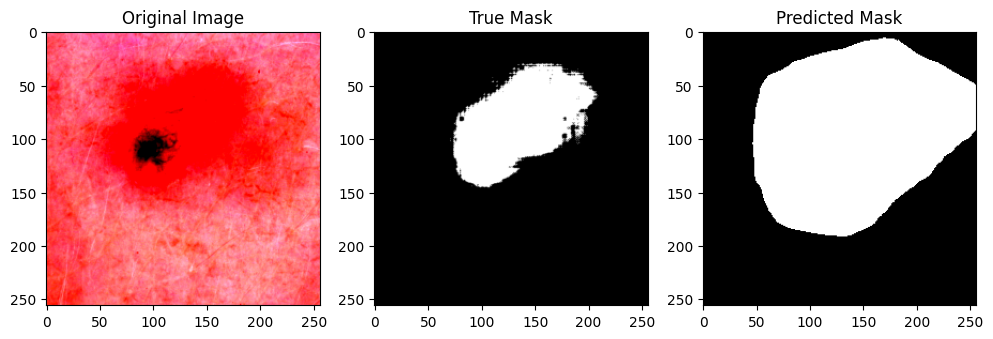

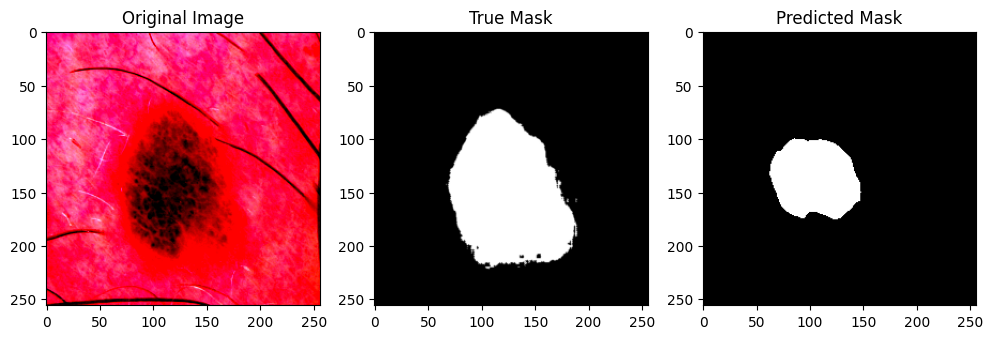

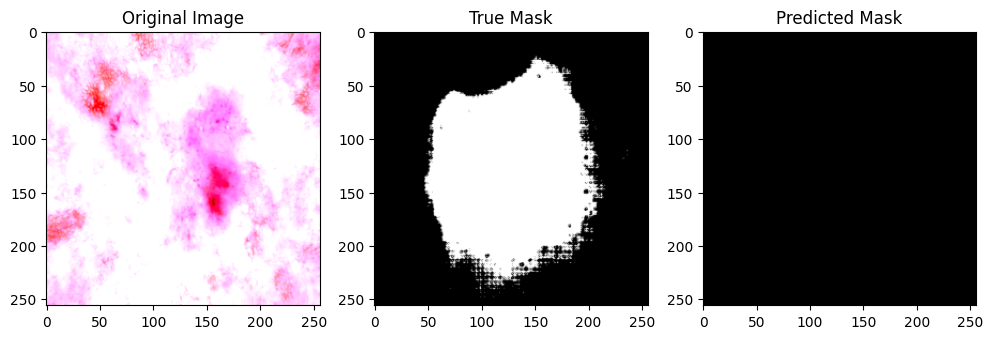

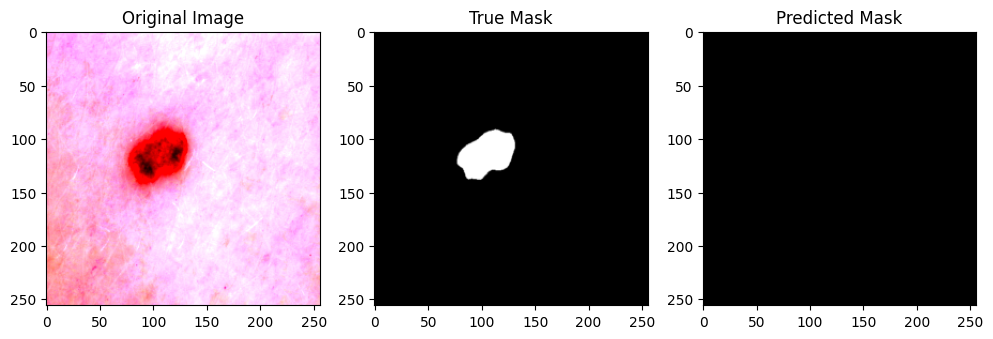

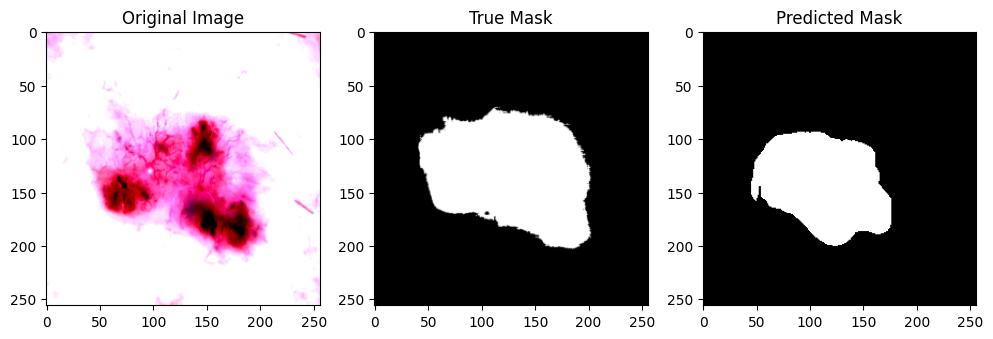

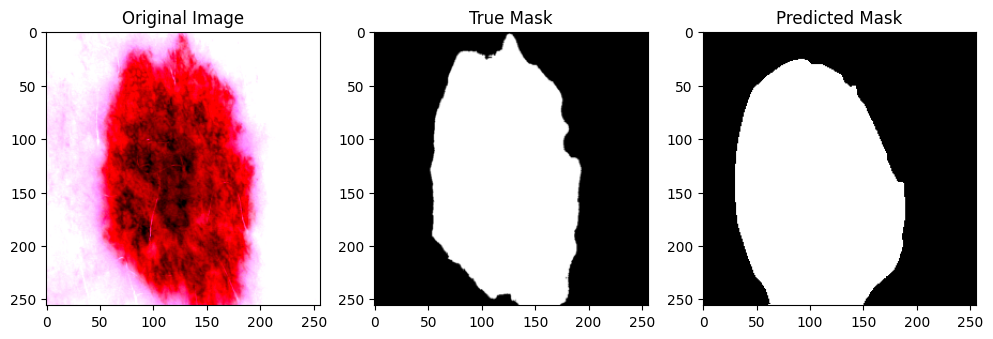

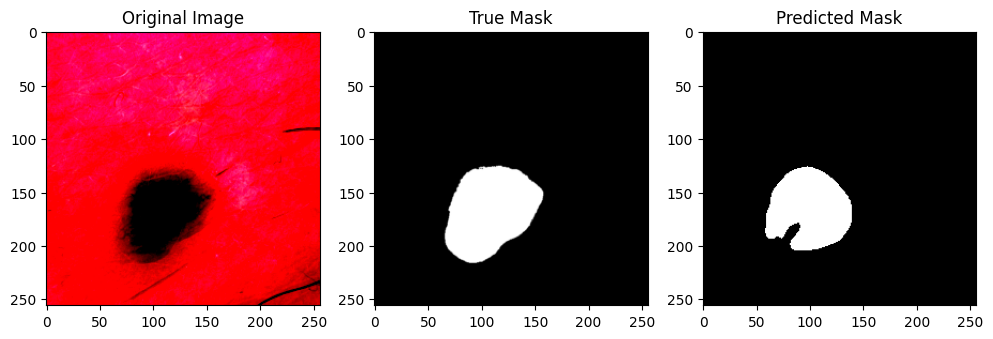

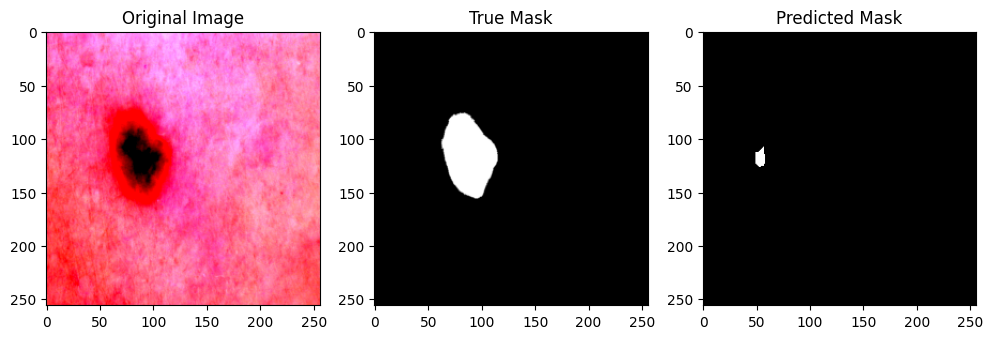

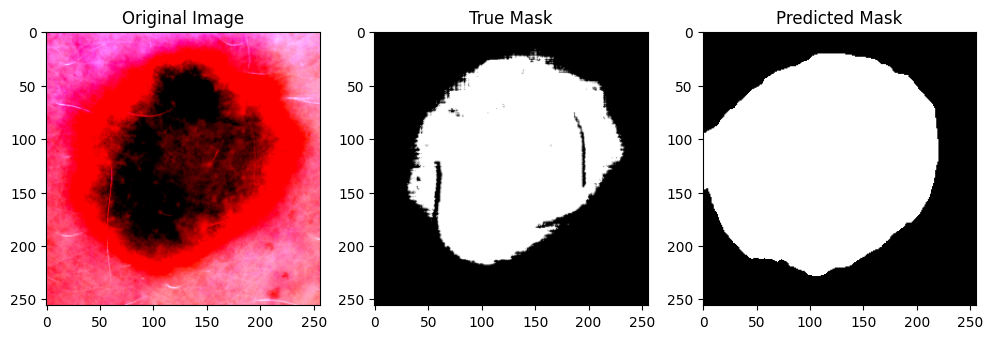

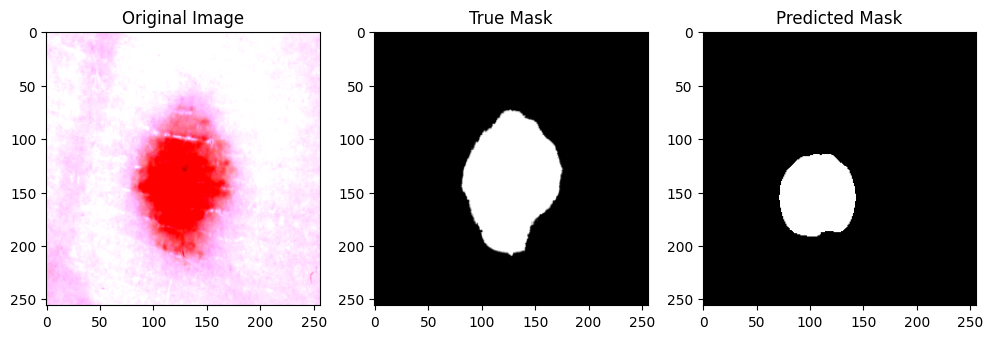

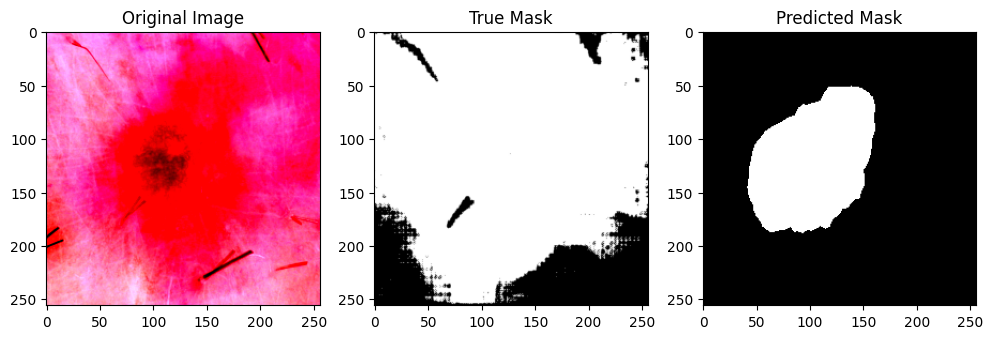

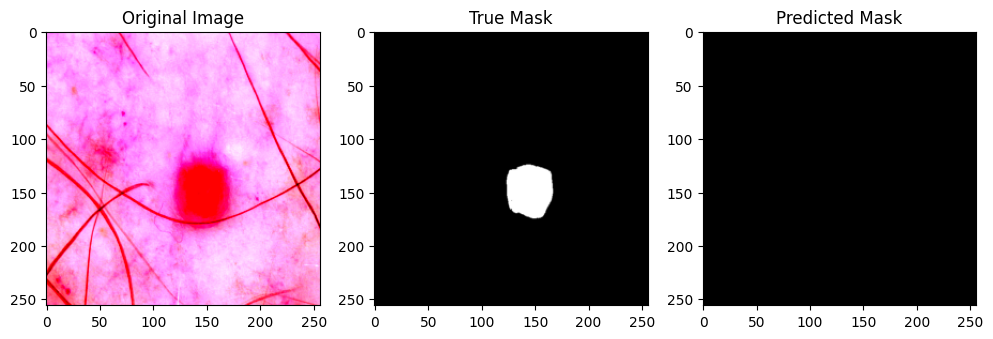

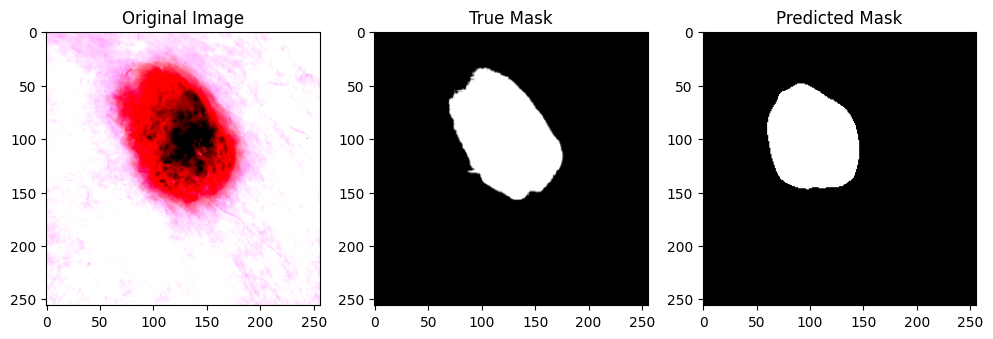

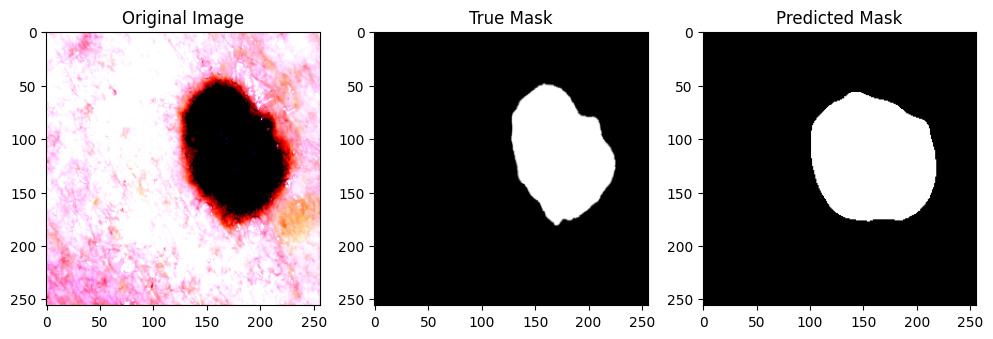

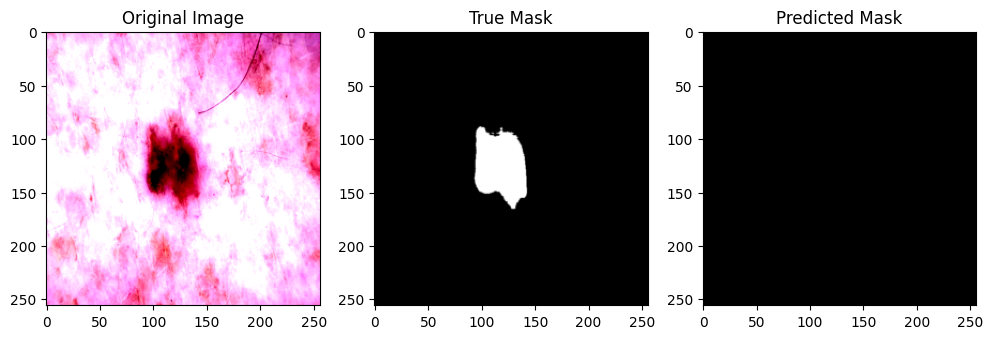

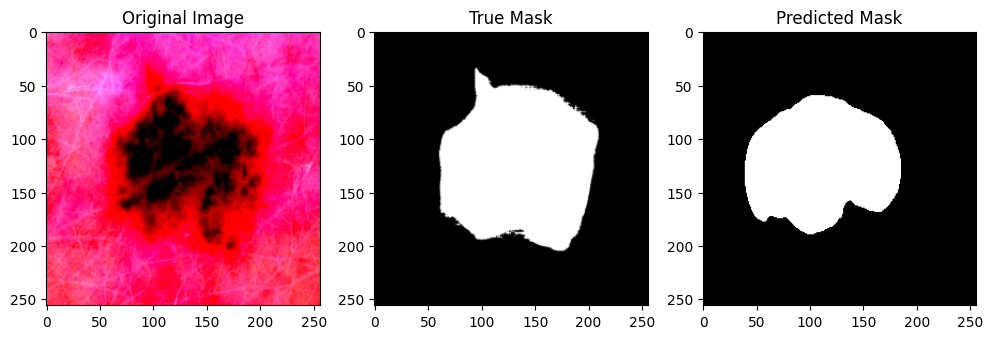

In [27]:
images, masks, filenames = next(iter(test_loader))
images, masks = images.to(device), masks.to(device)

with torch.no_grad():
    outputs = birefnet(images)
    outputs_tensor = extract_first_tensor(outputs)
    outputs_tensor = F.interpolate(outputs_tensor, size=masks.shape[-2:], mode="bilinear", align_corners=False)
    preds = torch.sigmoid(outputs_tensor) > 0.5  # Бинаризация

for i in range(len(images)):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(images[i].permute(1, 2, 0).cpu().numpy())
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(masks[i].squeeze().cpu().numpy(), cmap='gray')
    plt.title('True Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(preds[i].squeeze().cpu().numpy(), cmap='gray')
    plt.title('Predicted Mask')
    plt.show()


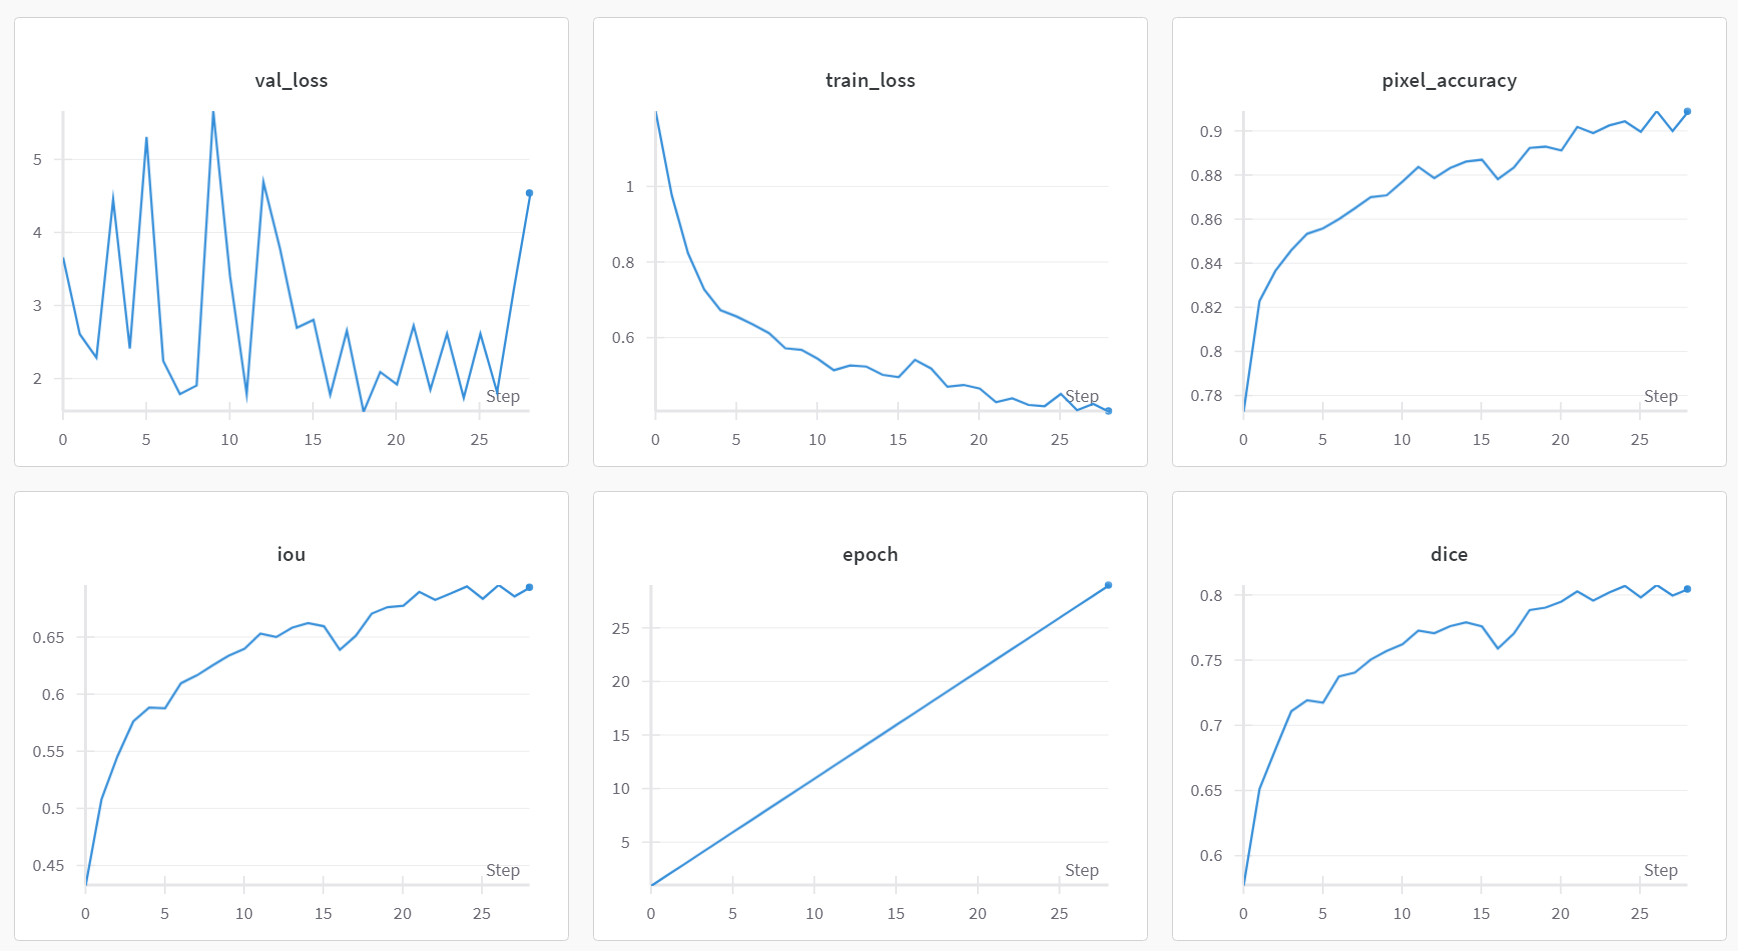